In [1]:
import os, sys
import torch
import numpy as np

import random

from models.DAB_DETR import build_DABDETR
from util.slconfig import SLConfig
from datasets.coco import build
from util.visualizer import COCOVisualizer
from util import box_ops
from typing import Any, Callable, Dict, Iterable, List, Optional, Set, Tuple, Union

/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!git clone --single-branch --branch add_dab_detr https://github.com/conditionedstimulus/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 187746, done.
remote: Counting objects: 100% (28299/28299), done.
remote: Compressing objects: 100% (2305/2305), done.
remote: Total 187746 (delta 27597), reused 25995 (delta 25993), pack-reused 159447 (from 1)
Receiving objects: 100% (187746/187746), 202.69 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (135884/135884), done.g deltas:  13% (17676/135884)
Updating files: 100% (4434/4434), done.


We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or load an image from a local path(see Sec. 2).

# 0. Init and Load Pre-trained Models

In [2]:
model_config_path = "model_zoo/DAB_DETR/R50DC5_pat3/config.json" # change the path of the model config file
model_checkpoint_path = "model_zoo/DAB_DETR/R50DC5_pat3/checkpoint.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.
# https://drive.google.com/drive/folders/1pae4Yxi0H9OOFdXZg3zXuKK9yOznhTNU

In [3]:
args = SLConfig.fromfile(model_config_path)
# args['num_patterns']=4

In [4]:
args

Config (path: model_zoo/DAB_DETR/R50DC5_pat3/config.json): {'lr': 0.0001, 'lr_backbone': 1e-05, 'batch_size': 1, 'weight_decay': 0.0001, 'epochs': 50, 'lr_drop': 40, 'save_checkpoint_interval': 100, 'clip_max_norm': 0.1, 'modelname': 'dab_detr', 'frozen_weights': None, 'backbone': 'resnet50', 'dilation': True, 'position_embedding': 'sine', 'pe_temperatureH': 20, 'pe_temperatureW': 20, 'batch_norm_type': 'FrozenBatchNorm2d', 'return_interm_layers': False, 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 300, 'pre_norm': False, 'num_select': 300, 'transformer_activation': 'prelu', 'num_patterns': 3, 'random_refpoints_xy': False, 'two_stage': False, 'num_feature_levels': 1, 'dec_n_points': 0, 'enc_n_points': 0, 'masks': False, 'aux_loss': True, 'set_cost_class': 2.0, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'cls_loss_coef': 1, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coe

In [5]:
model, criterion, postprocessors = build_DABDETR(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DABDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (activation): PReLU(num_parameters=1)
        )
      )
      (query_scale): MLP(
        (layers): ModuleList(
          (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (decoder): Transformer

In [6]:
args['coco_path']='/Users/davidhajdu/Desktop/data/coco'

# 1. Visualize images from dataloader
## 1.1 Load Datasets

In [7]:
dataset_val = build(image_set='val', args=args)
cocojs = dataset_val.coco.dataset
id2name = {item['id']: item['name'] for item in cocojs['categories']}

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


# 1.2 Get an Example and Visualize it

In [8]:
for x, y in dataset_val:
    if str(int(y['image_id'])) == '39769':
        cat_image = x
        data = y
        break

In [9]:
image, targets = cat_image, data

targets

{'boxes': tensor([[0.5503, 0.2765, 0.0604, 0.2215],
         [0.1695, 0.2016, 0.2080, 0.0940],
         [0.5006, 0.4933, 0.9978, 0.9865],
         [0.5008, 0.5002, 0.9983, 0.9955],
         [0.2627, 0.5456, 0.4707, 0.8646],
         [0.7715, 0.4115, 0.4570, 0.7161]]),
 'labels': tensor([75, 75, 63, 65, 17, 17]),
 'image_id': tensor([39769]),
 'area': tensor([  5887.9600,  11250.2061, 489353.8438, 837122.7500, 147967.5156,
         165732.3438]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([ 800, 1066])}

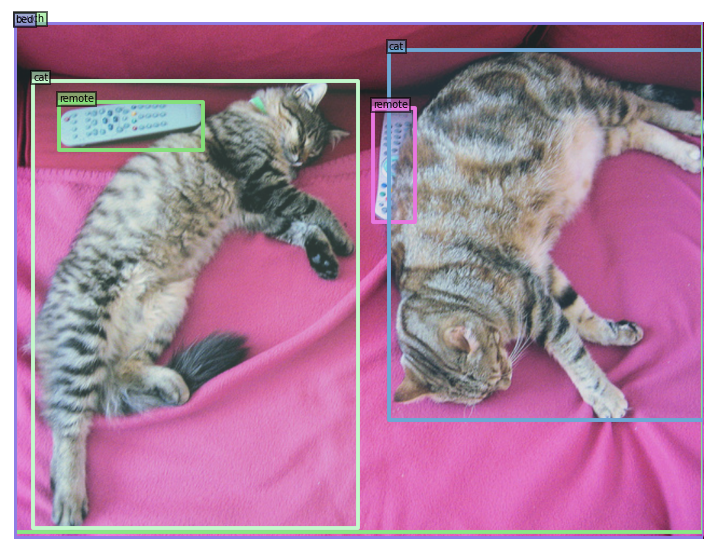

In [10]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [11]:
output_ = model(image[None])
output = postprocessors['bbox'](output_, torch.Tensor([[1.0, 1.0]]))[0]

In [12]:
output_['pred_logits']

tensor([[[-11.2264,  -5.4028,  -8.9815,  ...,  -7.0775,  -9.3987,  -9.3523],
         [-10.8721,  -6.0637,  -9.1898,  ...,  -7.3892,  -8.9347,  -8.7353],
         [-10.8535,  -6.8360,  -9.4203,  ...,  -8.5684, -10.0091,  -8.3398],
         ...,
         [-10.4971,  -6.4848,  -9.7062,  ...,  -7.3932,  -8.2373,  -6.9661],
         [-10.6210,  -6.2259, -10.1397,  ...,  -7.1374,  -8.2381,  -7.5859],
         [-11.1991,  -6.5501,  -9.0669,  ...,  -8.0283, -10.4693,  -9.8779]]],
       grad_fn=<SelectBackward0>)

In [13]:
output_['pred_boxes']

tensor([[[0.8532, 0.5143, 0.1799, 0.5210],
         [0.6903, 0.3749, 0.3506, 0.7464],
         [0.5275, 0.2726, 0.0535, 0.1184],
         ...,
         [0.6586, 0.4565, 0.2316, 0.5875],
         [0.3960, 0.2456, 0.1538, 0.2358],
         [0.3452, 0.7072, 0.4985, 0.5636]]], grad_fn=<SelectBackward0>)

In [14]:
thershold = 0.3 # set a threshold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

In [15]:
output['boxes']

tensor([[0.0621, 0.1525, 0.2766, 0.2482],
        [0.5331, 0.0499, 1.0017, 0.7694],
        [0.0185, 0.1049, 0.4972, 0.9842],
        ...,
        [0.3631, 0.0021, 0.7610, 0.1415],
        [0.5220, 0.1604, 0.5756, 0.3945],
        [0.5331, 0.0499, 1.0017, 0.7694]])

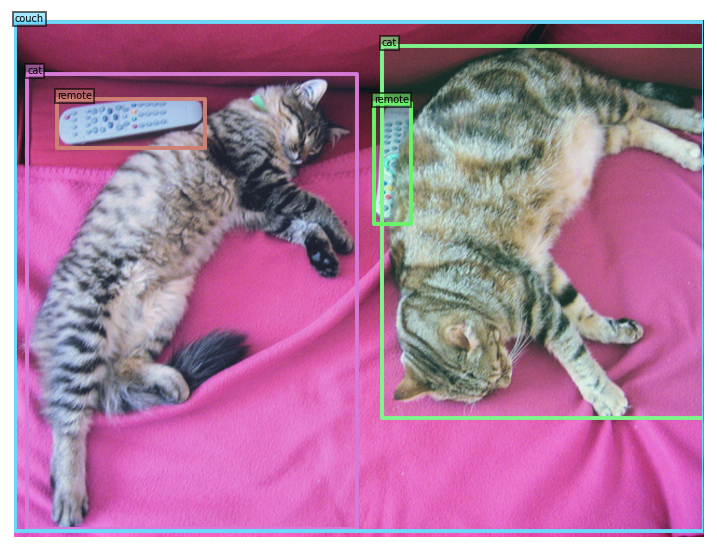

In [16]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

### Compare model outputs

In [17]:
from transformers2.src.transformers.models.dab_detr import DABDETRImageProcessor

image_processor = DABDETRImageProcessor.from_pretrained("davidhajdu/dab-detr-resnet-50")

In [18]:
from transformers2.src.transformers.models.dab_detr import DABDETRForObjectDetection
model = DABDETRForObjectDetection.from_pretrained("davidhajdu/dab-detr-resnet-50-dc5-pat3")

In [19]:
import requests
from PIL import Image

def prepare_img():
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    im = Image.open(requests.get(url, stream=True).raw)

    return im

In [20]:
im = prepare_img()

encoding = image_processor(im, return_tensors="pt")
model.eval()
hf_outputs = model(**encoding)

In [21]:
hf_logits = hf_outputs.logits
hf_pred_boxes = hf_outputs.pred_boxes

In [22]:
output_.keys()

og_logits = output_['pred_logits']
og_pred_boxes = output_['pred_boxes']

In [23]:
print(hf_logits)

print()

print(og_logits)

tensor([[[-11.2264,  -5.4027,  -8.9815,  ...,  -7.0774,  -9.3986,  -9.3521],
         [-10.8720,  -6.0637,  -9.1897,  ...,  -7.3891,  -8.9346,  -8.7352],
         [-10.8534,  -6.8360,  -9.4203,  ...,  -8.5684, -10.0092,  -8.3397],
         ...,
         [-10.4971,  -6.4848,  -9.7062,  ...,  -7.3932,  -8.2373,  -6.9660],
         [-10.6210,  -6.2258, -10.1396,  ...,  -7.1374,  -8.2379,  -7.5857],
         [-11.1990,  -6.5501,  -9.0670,  ...,  -8.0283, -10.4693,  -9.8778]]],
       grad_fn=<ViewBackward0>)

tensor([[[-11.2264,  -5.4028,  -8.9815,  ...,  -7.0775,  -9.3987,  -9.3523],
         [-10.8721,  -6.0637,  -9.1898,  ...,  -7.3892,  -8.9347,  -8.7353],
         [-10.8535,  -6.8360,  -9.4203,  ...,  -8.5684, -10.0091,  -8.3398],
         ...,
         [-10.4971,  -6.4848,  -9.7062,  ...,  -7.3932,  -8.2373,  -6.9661],
         [-10.6210,  -6.2259, -10.1397,  ...,  -7.1374,  -8.2381,  -7.5859],
         [-11.1991,  -6.5501,  -9.0669,  ...,  -8.0283, -10.4693,  -9.8779]]],
       grad

In [24]:
print(hf_pred_boxes)

print()

print(og_pred_boxes)

tensor([[[0.8532, 0.5143, 0.1799, 0.5210],
         [0.6903, 0.3749, 0.3506, 0.7464],
         [0.5275, 0.2726, 0.0535, 0.1184],
         ...,
         [0.6586, 0.4565, 0.2316, 0.5875],
         [0.3960, 0.2456, 0.1538, 0.2358],
         [0.3452, 0.7072, 0.4985, 0.5636]]], grad_fn=<SelectBackward0>)

tensor([[[0.8532, 0.5143, 0.1799, 0.5210],
         [0.6903, 0.3749, 0.3506, 0.7464],
         [0.5275, 0.2726, 0.0535, 0.1184],
         ...,
         [0.6586, 0.4565, 0.2316, 0.5875],
         [0.3960, 0.2456, 0.1538, 0.2358],
         [0.3452, 0.7072, 0.4985, 0.5636]]], grad_fn=<SelectBackward0>)


In [25]:
print(hf_logits.shape, og_logits.shape)
print(hf_pred_boxes.shape, og_pred_boxes.shape)

torch.Size([1, 900, 91]) torch.Size([1, 900, 91])
torch.Size([1, 900, 4]) torch.Size([1, 900, 4])


In [26]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [27]:
import torch

# rescale bounding boxes
target_sizes = torch.tensor(im.size[::-1], device=torch.device('cpu')).unsqueeze(0)
results = image_processor.post_process_object_detection(hf_outputs, threshold=0.3, target_sizes=target_sizes)[0]

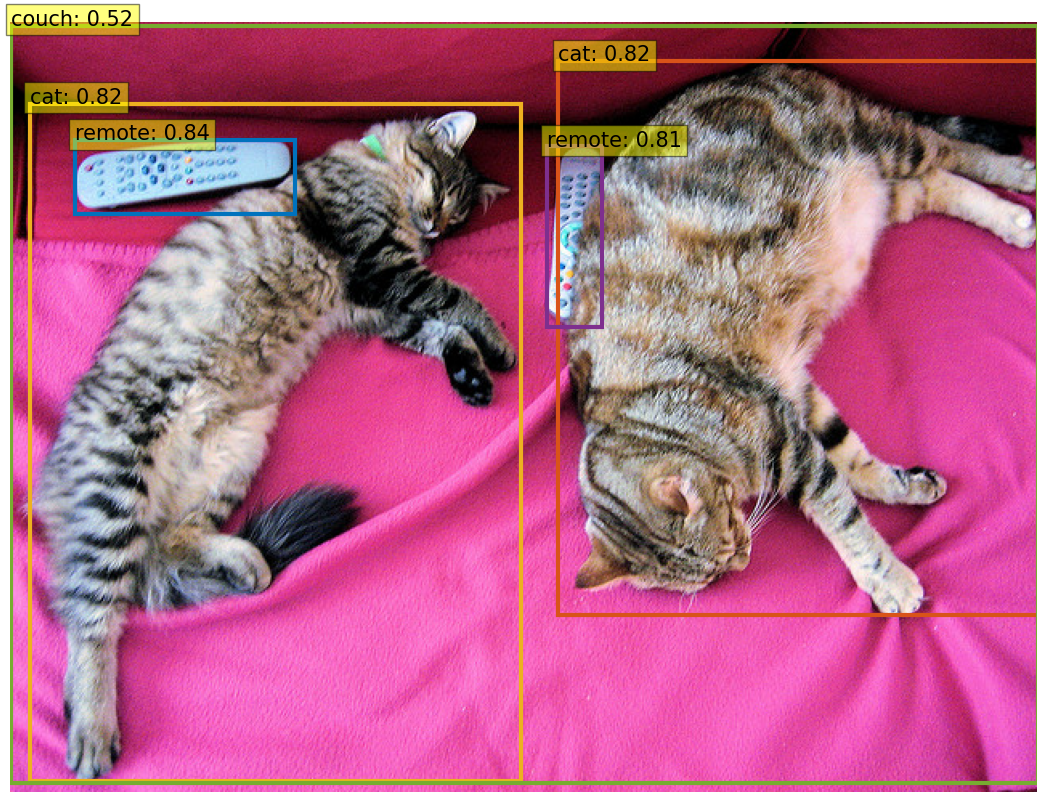

In [28]:
plot_results(im, results['scores'], results['labels'], results['boxes'])